# Warfish Dice-5: Efficacy Scores

> This notebook is part of a series which analyzes tactics for the online strategy game [Warfish](http://warfish.net/). If you're new to the game, check out our introduction first: [Warfish Dice-0 Introduction.ipynb](https://github.com/ZacButko/Probability-Playground/blob/master/Warfish%20Dice/Warfish%20Dice-0%20Introduction.ipynb). There we cover the rules for the game in general and discuss the 'attack' mechanic which lies at the center of our study for this series

We started off the series by doing a [rudimentary analysis](https://github.com/ZacButko/Probability-Playground/blob/master/Warfish%20Dice/Warfish%20Dice-1%20Single%20Throw%20Attack.ipynb) of single-attack probability. By running a Monte Carlo simulation we were able to see the likelyhood for each possible attack dynamic. While useful as a first order estimation, it wasn't clear how to use this information, especially for more complicated outcomes. We tried attacking this problem from several angles and as a result found some interesting results about start to finish "fight to the death" scenarios by [plotting all intermediate states](https://github.com/ZacButko/Probability-Playground/blob/master/Warfish%20Dice/Warfish%20Dice-2%20Full%20Stack%20%22Fight%20to%20the%20Death%22.ipynb) and synthesizing just the final outcomes into [At Least Graphs](https://github.com/ZacButko/Probability-Playground/blob/master/Warfish%20Dice/Warfish%20Dice-3%20At%20Least%20Graphs.ipynb). However, there was something still lacking in terms of knowing the most optimal single-attack tactic for any situation a player would find themselves in. We still needed a common unifying score to quantify the efficacy of all possible single-attack patterns.

Below we propose a solution by running a Bernoulli process to sample single-attack scenarios to gain our desired key metrics; expectation and variance. Additionally, we sample from a binomial distribution in order to give some visual feel to how these metrics play out over the course of the game.

## Setup dice rolls and battle mechanics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg
import matplotlib.gridspec as grid_spec
# import scipy.stats as stats
import math

In [3]:
rng = np.random.default_rng()

# this rolls n_dice with n_sides once each. 
def roll_dice(n_sides, n_dice):
    return (rng.integers(low = 1, high = n_sides, size = n_dice, endpoint=True)).tolist()

# Main logic for resolving one 'round'
# Highest rolls from attacker are compared against highest rolls from defender
# Defender wins ties
def resolve_battle(a_rolls, d_rolls, debug=False):
    nad = len(a_rolls)
    ndd = len(d_rolls)
    min_die = min([nad, ndd])
    a_rolls.sort(reverse=True)
    d_rolls.sort(reverse=True)
    score = {'attack':0, 'defend':0, 'tracker':[]}
    if debug:
        print('a rolls: ', a_rolls)
        print('d rolls: ', d_rolls)
    for i in range(min_die):
        if a_rolls[i] > d_rolls[i]:
            score['defend'] -= 1
            score['tracker'].append(0)
        else:
            score['attack'] -= 1
            score['tracker'].append(1)
    if debug: print(score)
    return score   

In [4]:
# checking our resolve_battle() logic
# This counts as one 'Bernoulli trial'
score = resolve_battle(roll_dice(6, 3), roll_dice(6, 2), debug=True)

a rolls:  [6, 1, 1]
d rolls:  [6, 1]
{'attack': -2, 'defend': 0, 'tracker': [1, 1]}


## Run a Bernoulli process on one single-attack configuration
This is essentially the same as what we were calling a Monte Carlo simulation in previous notebooks. One key difference here is that we now treat multiple attacks from the same round as separate Bernoulli trials. 

**Things we need to beware of:** While the first and second attack in a 2-attack round technically have different probabilities, because they always occur in concert for any one single-attack configuration, the resultant probability does not change, and therefore we maintain our Bernoulli trial assumption. We should also beware that considering n_rounds=10k for 1-attack rounds will result in 10k samples, while running 10k rounds at 2-attack rounds will result in 20k samples. We are fortunate here that both expectation and variance of a Bernoulli distribution are independent of N trials. The only value we need to be confident in is p, and due to the central limit theorem of the Bernoulli process, we only need to run enough trials until our expectation value p is stable to our desired level of precision.

Because separate attacks within one round are treated as atomic acts, we can now compare rounds of 1 attack with rounds of 2 attacks in a newly formed "attackers lost per attacker wagered" metric. This is the great advantage we were looking for.

In [23]:
# Main logic for sampling an attack configuration
def collect_samples(n_a_dice, n_d_dice, n_a_sides=6, n_d_sides=6, n_rounds=10000, debug = False):
    dice_fighting_per_round = min([n_a_dice, n_d_dice])
    attackers_lost = 0
    round_tracker = []
    
    # collect n_rounds worth of data
    for i in range(n_rounds):
        this_round = resolve_battle(roll_dice(n_a_sides, n_a_dice), roll_dice(n_d_sides, n_d_dice))
        round_tracker += this_round['tracker']
        attackers_lost -= this_round['attack']
    if debug:
        print('attackers lost: ', attackers_lost)
        print('attackers wagered: ', (n_rounds * dice_fighting_per_round))
        
    # get a histo of results
    # turning on density normalizes this for us
    # this will make two buckets for us, one containing [0,1) and the other [1,2)
    bins = [0,1,2] 
    histo, edges = np.histogram(round_tracker, bins=bins,density=True)
    if debug: print('histo: ',histo)
    
    # expectation value = p = the probability mass found at 1
    expectation = histo[1]
    # variance is p(1-p)
    variance = expectation * (1- expectation)
    if debug:
        print('expectation: {0:.2f}'.format(expectation))
        print('variance: {0:.2f}'.format(variance))
  
    return expectation, variance, histo, edges

attackers lost:  9159
attackers wagered:  20000
histo:  [0.54205 0.45795]
expectation: 0.46
variance: 0.25


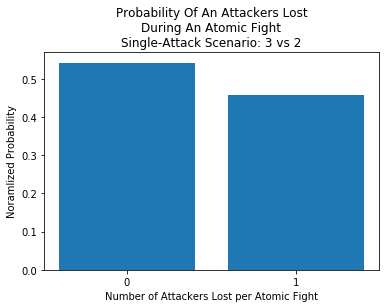

In [24]:
# checking collect_samples()
m, v, h, e = collect_samples(3, 2, debug=True)
plt.bar(e[:-1], h)
plt.xticks([0,1])
plt.title("Probability Of An Attackers Lost\nDuring An Atomic Fight\nSingle-Attack Scenario: 3 vs 2")
plt.xlabel("Number of Attackers Lost per Atomic Fight")
plt.ylabel("Noramlized Probability")
plt.show()

Great. We've run our Bernoulli process and found p, the total probability found at x=1. In this case p = .46, and q = 1-p = .54. While can sort of appreciate the meaning behind the histogram (we ran n trials, in total that many attackers were lost), we still don't have a feel for the underlying distribution which generated the histogram

The suspense is over because we know what function generated that histogram:

![Bernoulli Function](img/BernoulliFx.png)

Sampling uniformly from this distribution will generate the histogram above.

Well that was pretty underwhelming. What about the variance? How can we get a feel for what our odds of various outcomes look like over the course of the game? We know that if we attack 3 vs 2 each time we do that we expect to lose 0.46 attackers. But what if we fight with this configuration 10 times and lost 8 attackers? What's the probability of that? Is it more likely to lose 3 attackers or 7 attackers over the course of 10 rounds? 

For a more intuitive feel for how these probabilities play out over the course of the game, we now turn to the binomial distribution

## Sampling from the binomial distribution

The binomial distribution gives probability to the number of successes in n independent Bernoulli trials for some n. If we flip 10 independent coins and are counting the number of heads we expect that the highest probable outcome is centered around 5. But how high is this probability? What is the probability that 9 out of 10 coins came back heads? This is what a binomial distribution represents.

For n independent Bernoulli trials the pdf of the binomial distribution is given by:

>$p(z) = $$\binom{n}{k}$$p^z$$(1-p)^n$$^-$$^z$ for z = 0,1,...,n
<br><br>
>where $\binom{n}{k}$ = $\frac{n!}{k!(n-k)!}$

In [25]:
# Sample from the bionomial distribution to plot a Bernoulli PDF
def sample_binomial(p, n):
    distribution = [ c_of_n_x(n,z) * np.power(p, z) * np.power(1-p, n-z) for z in range(n+1)]
    return distribution

# supporting function for sample_binomial
def c_of_n_x(n,x):
    numerator = math.factorial(n)
    denominator = math.factorial(x) * math.factorial(n-x)
    return numerator/denominator

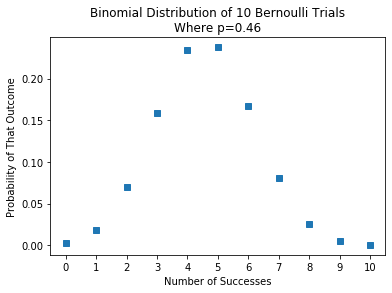

In [26]:
# checking our binomial distribution sampler
n_samples = 10
plt.plot(range(0,n_samples+1),sample_binomial(m, n_samples),'s')
ax = plt.gca()
ax.set_xticks(np.arange(0,11))
ax.set_xlabel("Number of Successes")
ax.set_ylabel("Probability of That Outcome")
ax.set_title('Binomial Distribution of {0} Bernoulli Trials\nWhere p={1:.2f}'.format(n_samples,m))
plt.show()

## Plotting many together

In [27]:
# run scenarios to generate data to plot
# colorcodes each scenario
# keeps track of descriptive stats (expectation value and variance)
def run_scenarios(scenarios, n_throws=10000, n_bins=10):
    # Important to keep the number of bins small otherwise Bernoulli is 
    # too confident / narrows out too much which is not reflected in our experiments

    x = range(n_bins+1)
    y = []
    c = []
    cm = plt.cm.get_cmap('YlOrRd')
    stats = []
    for i in range(len(scenarios)):
        scenarios[i].append(n_throws)
    for args in scenarios:
        m, s, h, e = collect_samples(*args)
        stats.append( [m, s] )
        y += [ sample_binomial(m, n_bins) ]
        c += [cm(m)]
    
    return x, y, c, stats, n_bins

In [32]:
# plotting stuff
def plot_ridgeplot(x, y, c, stats, names, n_trials):
    gs = (grid_spec.GridSpec(len(scenarios),1))
    hspace = -.5
    ymax = .4

    fig = plt.figure(figsize=(15,10))
    fig.suptitle("Probability Distribution of Attacker Loss per Attacker Wagered\nDefender Loss = 1 - Attacker Loss", fontsize=18, y=0.9)

    ax_objs = []
    for i in range(len(names)):
        # make a new axis and keep track of it in ax_objs
        ax_objs.append( fig.add_subplot(gs[i:i+1, 0:]) )
        ax = ax_objs[-1]
        # plot
        ax.plot(x, y[i])
        ax.fill_between(x,y[i], color = c[i])
        ax.set_ylim(0,ymax)
        ax.set_xlim(0,10)
        # make background transparent
        rect = ax.patch
        rect.set_alpha(0)
        # remove borders, axis ticks, labels
        ax.set_yticks([])
        ax.set_ylabel('')
        if i != len(names)-1:
            ax.set_xticks([])
        else:
            ax.set_xticks(range(0,n_trials+1))
            ax.set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
            ax.set_xlabel("Attackers Lost")
            #attempting to make a bar showing .5 or the symetry point on top of all plots is a challenge for another day..
            #ax.set_ylim(0,ymax*len(names)*(-hspace))
            #ax.axvline(x=.5*n_bins, ymin=0, ymax=(len(names)*(-hspace)))
        for s in ['top','right','left','bottom']:
            ax.spines[s].set_visible(False) 
        ax.text(-0.2,0,names[i], fontweight='bold',fontsize=14,ha='right')
        # expected value = n_trials * p
        ax.axvline(x=stats[i][0] * n_trials, ymin=0, ymax=.5, color='b')
        # variance = n*q*p
        ax.axvline(x=(stats[i][0] * n_trials + stats[i][1]*n_trials), ymin=0, ymax=.2, color='w')
        ax.axvline(x=(stats[i][0] * n_trials - stats[i][1]*n_trials), ymin=0, ymax=.2, color='w')
        ax.text((stats[i][0]*n_trials + .15), 0.15 ,'{0:.2f}'.format(stats[i][0]))

    # make plots overlap eachother
    gs.update(hspace=hspace)

    plt.show()

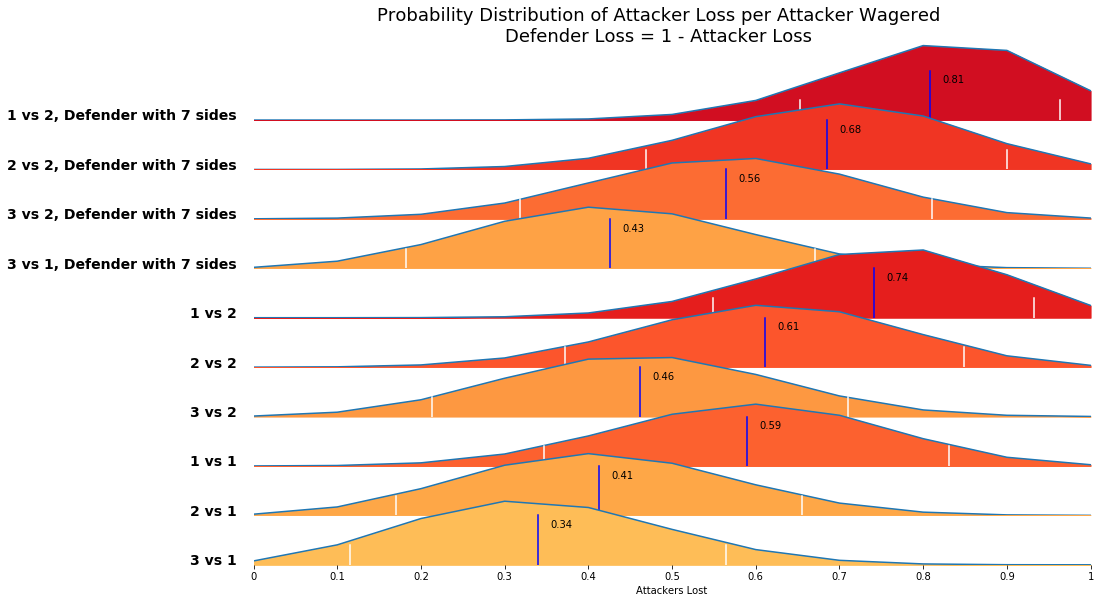

In [33]:
# specify tests we are going to run
scenarios = [
    [3,1, 6, 6],
    [2,1, 6, 6],
    [1,1, 6, 6],
    [3,2, 6, 6],
    [2,2, 6, 6],
    [1,2, 6, 6],
    [3,1, 6, 7],
    [3,2, 6, 7],
    [2,2, 6, 7],
    [1,2, 6, 7]
]
names = [
    '3 vs 1',
    '2 vs 1',
    '1 vs 1',
    '3 vs 2',
    '2 vs 2',
    '1 vs 2',
    '3 vs 1, Defender with 7 sides',
    '3 vs 2, Defender with 7 sides',
    '2 vs 2, Defender with 7 sides',
    '1 vs 2, Defender with 7 sides',
]
scenarios.reverse()
names.reverse()

x, y, c, stats, n_bins = run_scenarios(scenarios)
plot_ridgeplot(x,y,c,stats,names,n_bins)

# Conclusion
Having an expectation of how many troops you need to wager in order to make a successful attack is key to planning a strategy with Warfish. Knowing whether to stay put on high ground or attack downwards based on your losses (p) and your opponent's losses (1-p) can help pave the way to victory.

Consider the following situation:<br>![5vs3](img/5v3.png "5vs3")<br>
Blue, being worried that their defenses are about to be breached, can wait for brown to attack up, blue enjoys a 7-sided-dice hill defense bonus. Another option is being pro-active about attacking down at the looming threat, although this is just a normal 6-sided vs 6-sided attack. Checking our expected losses above we see that if blue uses the maximized attack-down option waging 3vs2 (n_a_sides=n_d_sides=6), they can expect to lose 0.46 attackers for every 1 wagered. If they wait for brown to attack up, brown using maximized '3vs2, Defender with 7 sides' tactic will lose .56 attackers for every one wagered. Since defender loss = 1-attacker loss, blue will lose .44 troops in this case. Comparing blue's losses, 0.46 for attacking first, or 0.44 for staying defensive, we can see there is a very small advantage in staying put with hill defensive bonus. 

Although it's important to be mindful! The variance on all these estimations is large, so while you might have the superior strategy backed by data, real dice rolls never listen to our wishes.

Finally, one must consider the cumulative effect of all attacks. Attacking multiple times with the same dynamics doesn't change the underlying probability function, however once defenses are down the attacker gets extra probability of success. Likewise attacking a strongly defended enemy with few resources left quickly leads to failure. Consideration of how these probabilities stack together in real rounds is considered in a previous workbook: [Warfish Dice-3 At Least Graphs.ipynb](https://github.com/ZacButko/Probability-Playground/blob/master/Warfish%20Dice/Warfish%20Dice-3%20At%20Least%20Graphs.ipynb)